<a href="https://colab.research.google.com/github/Deepak-Mewada/NeuralDecoder/blob/main/BrainDecoder/Basics/Data_augmentation_on_BCICIV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install braindecode
!pip install moabb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.2/165.2 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.3/239.3 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 563.8/563.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.2/119.2 kB 15.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 17.8 MB/s eta 0:00:00
  Created wheel for pyriemann: filename=pyriemann-0.5-py2.py3-none-any.whl size=107752 sha256=d0ced297d12e61de6bc4bd78db8c1c2fc466e77f75c02befa992

In [ ]:
from skorch.helper import predefined_split
from skorch.callbacks import LRScheduler

from braindecode import EEGClassifier
from braindecode.datasets import MOABBDataset

subject_id = 3
dataset = MOABBDataset(dataset_name="BNCI2014001", subject_ids=[subject_id])

<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_channels_regexp is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.channel_type is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
/usr/local/lib/python3.10/dist-packages/moabb/pipelines/__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(
/usr/local/lib/python3.10/dist-packages/moabb/datasets/download.py:55: RuntimeWarning: Setting non-standard config type: "MNE_DATASETS_BNCI_P

MNE_DATA is not already configured. It will be set to default location in the home directory - /root/mne_data
All datasets will be downloaded to this location, if anything is already downloaded, please move manually to this location


100%|█████████████████████████████████████| 44.1M/44.1M [00:00<00:00, 27.9GB/s]
SHA256 hash of downloaded file: 7e731ee8b681d5da6ecb11ae1d4e64b1653c7f15aad5d6b7620b25ce53141e80
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'lampx.tugraz.at'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  >>> conn = connection_from_url('http://google.com/')
100%|█████████████████████████████████████| 42.3M/42.3M [00:00<00:00, 7.05GB/s]
SHA256 hash of downloaded file: d4229267ec7624fa8bd3af5cbebac17f415f7c722de6cb676748f8cb3b717d97
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


In [ ]:
from braindecode.preprocessing import (
    exponential_moving_standardize, preprocess, Preprocessor)
from numpy import multiply

low_cut_hz = 4.
high_cut_hz = 38.

factor_new = 1e-3
init_block_size = 1000

factor = 1e6

preprocessors = [
    Preprocessor('pick_types', eeg=True, meg=False, stim=False),
    Preprocessor(lambda data: multiply(data, factor)),
    Preprocessor('filter', l_freq=low_cut_hz, h_freq=high_cut_hz),
    Preprocessor(exponential_moving_standardize,
                 factor_new=factor_new, init_block_size=init_block_size)
]

preprocess(dataset, preprocessors, n_jobs=-1)

/usr/local/lib/python3.10/dist-packages/braindecode/preprocessing/preprocess.py:55: UserWarning: Preprocessing choices with lambda functions cannot be saved.
  warn('Preprocessing choices with lambda functions cannot be saved.')


In [ ]:
from braindecode.preprocessing import create_windows_from_events

trial_start_offset_seconds = -0.5

sfreq = dataset.datasets[0].raw.info['sfreq']
assert all([ds.raw.info['sfreq'] == sfreq for ds in dataset.datasets])

trial_start_offset_samples = int(trial_start_offset_seconds * sfreq)


windows_dataset = create_windows_from_events(
    dataset,
    trial_start_offset_samples=trial_start_offset_samples,
    trial_stop_offset_samples=0,
    preload=True,
)

Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']


In [ ]:
splitted = windows_dataset.split('session')
train_set = splitted['0train']
valid_set = splitted['1test']

In [ ]:
from braindecode.augmentation import FrequencyShift

transform = FrequencyShift(
    probability=1.,
    sfreq=sfreq,
    max_delta_freq=2.
)

In [ ]:
import torch
import numpy as np

X = np.stack([X for X, y, i in train_set.datasets[0]])
X_tr, _ = transform.operation(torch.as_tensor(X).float(), None, 10., sfreq)

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


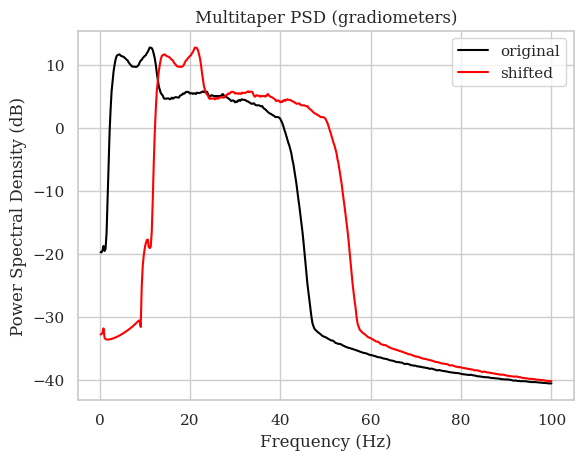

In [ ]:
import mne
import matplotlib.pyplot as plt


def plot_psd(data, axis, label, color):
    psds, freqs = mne.time_frequency.psd_array_multitaper(data, sfreq=sfreq,
                                                          fmin=0.1, fmax=100)
    psds = 10. * np.log10(psds)
    psds_mean = psds.mean(0).mean(0)
    axis.plot(freqs, psds_mean, color=color, label=label)


_, ax = plt.subplots()
plot_psd(X, ax, 'original', 'k')
plot_psd(X_tr.numpy(), ax, 'shifted', 'r')

ax.set(title='Multitaper PSD (gradiometers)', xlabel='Frequency (Hz)',
       ylabel='Power Spectral Density (dB)')
ax.legend()
plt.show()

In [ ]:
from braindecode.util import set_random_seeds
from braindecode.models import ShallowFBCSPNet

cuda = torch.cuda.is_available()
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True


seed = 20200220
set_random_seeds(seed=seed, cuda=cuda)

n_classes = 4
classes = list(range(n_classes))


n_channels = train_set[0][0].shape[0]
input_window_samples = train_set[0][0].shape[1]

model = ShallowFBCSPNet(
    n_channels,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length='auto',
)


/usr/local/lib/python3.10/dist-packages/braindecode/models/base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


In [ ]:
from braindecode.augmentation import AugmentedDataLoader, SignFlip

freq_shift = FrequencyShift(
    probability=.5,
    sfreq=sfreq,
    max_delta_freq=2.
)

sign_flip = SignFlip(probability=.1)

transforms = [
    freq_shift,
    sign_flip
]
if cuda:
    model.cuda()

In [ ]:
lr = 0.0625 * 0.01
weight_decay = 0

batch_size = 64
n_epochs = 4

clf = EEGClassifier(
    model,
    iterator_train=AugmentedDataLoader,
    iterator_train__transforms=transforms,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.AdamW,
    train_split=predefined_split(valid_set),
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        "accuracy",
        ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
    classes=classes,
)

clf.fit(train_set, y=None, epochs=n_epochs)

  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2500        1.6077       0.2500            0.2500        3.0176  0.0006  9.7853
      2            0.2569        1.3809       0.2569            0.2569        2.1895  0.0005  4.8348
      3            0.3021        1.2767       0.2569            0.2569        1.7959  0.0002  5.8864
      4            0.3229        1.1763       0.2674            0.2674        1.6416  0.0000  4.9270


<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=============================================================================================================================================
  Layer (type (var_name):depth-idx)        Input Shape               Output Shape              Param #                   Kernel Shape
  ShallowFBCSPNet (ShallowFBCSPNet)        [1, 22, 1125]             [1, 4]                    --                        --
  ├─Ensure4d (ensuredims): 1-1             [1, 22, 1125]             [1, 22, 1125, 1]          --                        --
  ├─Rearrange (dimshuffle): 1-2            [1, 22, 1125, 1]          [1, 1, 1125, 22]          --                        --
  ├─CombinedConv (conv_time_spat): 1-3     [1, 1, 1125, 22]          [1, 40, 1101, 1]          36,240                    --
  ├─BatchNorm2d (bnorm): 1-4               [1, 40, 1101, 1]          [1, 40, 1101, 1]          80                        --
  ├─Expression (conv_nonlin_exp): 

In [ ]:
from braindecode.augmentation import Compose

composed_transforms = Compose(transforms=transforms)

In [ ]:
train_set.transform = composed_transforms